In [50]:
import numpy as np
from sklearn.linear_model import LassoCV, ElasticNetCV, lasso_path, enet_path, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from modopt.opt.proximity import KSupportNorm, SparseThreshold, ElasticNet
from modopt.opt.linear import Identity
from sklearn.preprocessing import normalize, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 35


In [30]:
rs = np.random.RandomState(2)
w11, w12, w13 = 9/11, 6/11, 2/11
w21, w22, w23 = 1/3, 14/15, 2/15
w31, w32, w33 = 1, 1, -4
X1 = rs.randn(4)
X2 = rs.randn(4)
X3 = rs.randn(4)
X4 = w11 * X1 + w12 * X2 + w13 * X3
X5 = w21 * X1 + w22 * X2 + w23 * X3
x0 = np.array([w31, w32, w33, 0., 0.])
y = w31 * X1 + w32 * X2 + w33 * X3
X = np.hstack([X1[:, None], X2[:, None], X3[:, None], X4[:, None], X5[:, None]])

In [31]:
X /= 4
y /= 4

In [32]:
def run_irksn(n_iter):
    alpha = 0.001
    k = 3
    beta = np.zeros(X.shape[1])
    beta_sum = beta + 0.
    beta_avg = beta + 0.
    v = np.zeros(X.shape[0])
    z = np.zeros(X.shape[0])
    z_old = np.zeros(X.shape[0])
    nuclear_norm = np.linalg.norm(X, ord='nuc')
    gamma = 0.5 * alpha * nuclear_norm**(-2)
    theta = 1
    prox = KSupportNorm(beta=(1 - alpha)/alpha, k_value=k)
    losses, sparsity = [], []
    betas = []
    print((2 * nuclear_norm * np.linalg.norm(np.linalg.pinv(X[:, :3].T) @ x0[:3]))/alpha)
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        
        beta = prox.op(- 1/alpha * X.T @ z)
        r = prox.op(- 1/alpha * X.T @ v)
        z_old = z + 0.
        z = v + gamma * (X @ r - y)
        theta_old = theta + 0.
        theta = (1 + np.sqrt(1 + 4 * theta ** 2))/2
        v = z + (theta_old - 1)/(theta) * (z - z_old)
    betas = np.hstack(betas)
    return sparsity, losses, betas

In [33]:
spasrsity, losses, betas = run_irksn(5000)

38122.48866911708


/Users/william.vezelhes/miniconda3/envs/ksn/lib/python3.11/site-packages/modopt/opt/proximity.py:1021: RuntimeWarning: divide by zero encountered in scalar divide
  return (self._k_value - b_val) / slope


In [34]:
from sklearn.linear_model import lasso_path
eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8)

Computing regularization path using the lasso...
Computing regularization path using the elastic net...


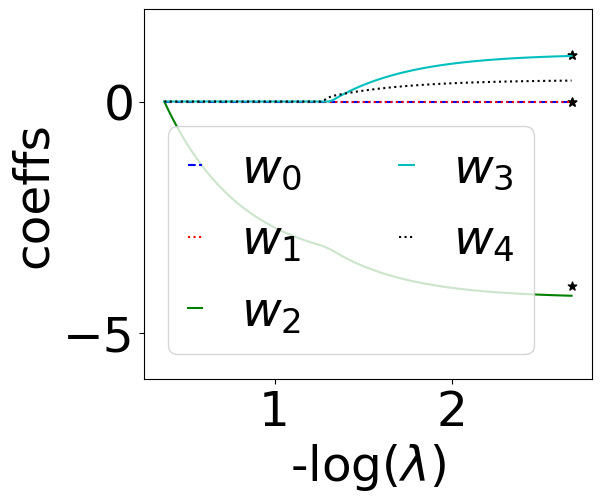

In [90]:
from itertools import cycle
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
names = ['$w^{(y)}_0,$', '$ ~~~~~~~~ w^{(y)}_1$', '$w^{(y)}_2$', '$w^{(y)}_3,$', '$ ~~~~~~~~ w^{(y)}_4$' ]
motives = ['--', ':', '-', '-', ':']
neg_log_alphas_lasso = -np.log10(alphas_lasso)
for i, (coef_e, c) in enumerate(zip(coefs_lasso, colors)):
    l2 = plt.plot(neg_log_alphas_lasso, coef_e, motives[i], c=c, label=f'$w_{i}$')
    # plt.legend(loc='lower left', handlelength=0.5)
# 

markers = ["<", ">", "v", "^", "*"]

for i, (wi, c, m) in enumerate(zip([1, 1, -4, 0, 0], colors, markers)):
    plt.scatter([neg_log_alphas_lasso[-1]], [wi], c='black', marker='*', s=40)
    # plt.text(neg_log_alphas_lasso[-1]+ 0.2 , wi, names[i])


plt.xlabel("-log($\lambda$)")
plt.ylabel("coeffs")
# plt.title("Lasso Path")
plt.axis("tight")
plt.ylim(-6, 2)


legend = plt.legend(loc='lower left', handlelength=0.3, ncol=2)
# frame = legend.get_frame()
# frame.set_edgecolor('none')  # Make legend box contours transparent
# frame.set_facecolor('none') 
plt.subplots_adjust(left=0.2)

plt.show()


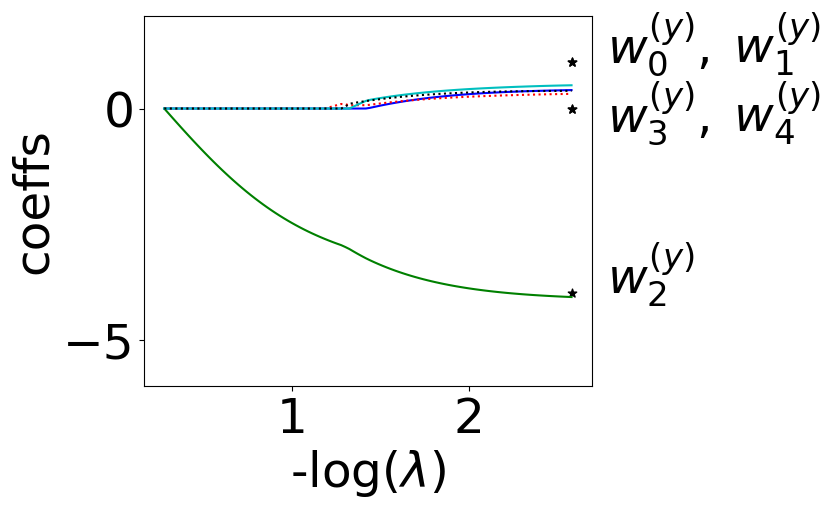

In [91]:
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
names = ['$w^{(y)}_0,$', '$ ~~~~~~~~ w^{(y)}_1$', '$w^{(y)}_2$', '$w^{(y)}_3,$', '$ ~~~~~~~~ w^{(y)}_4$' ]
motives = ['-', ':', '-', '-', ':']
neg_log_alphas_enet = -np.log10(alphas_enet)
for i, (coef_e, c) in enumerate(zip(coefs_enet, colors)):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, motives[i], c=c, label=f'$w_{i}$')
    # plt.legend(loc='lower left', handlelength=0.4)


markers = ["<", ">", "v", "^", "*"]


for i, (wi, c, m) in enumerate(zip([1, 1, -4, 0, 0], colors, markers)):
    if i == 3 or i == 4:
        position = wi - 0.5
    else:
        position = wi

    plt.scatter([neg_log_alphas_enet[-1]], wi, c='black', marker='*', s=40)
    plt.text(neg_log_alphas_enet[-1]+ 0.2 , position, names[i])


plt.xlabel(f"-log($\lambda$)")
plt.ylabel("coeffs")
# plt.title("Elastic-Net Path")
plt.axis("tight")
plt.ylim(-6, 2)
plt.subplots_adjust(left=0.2)

plt.show()


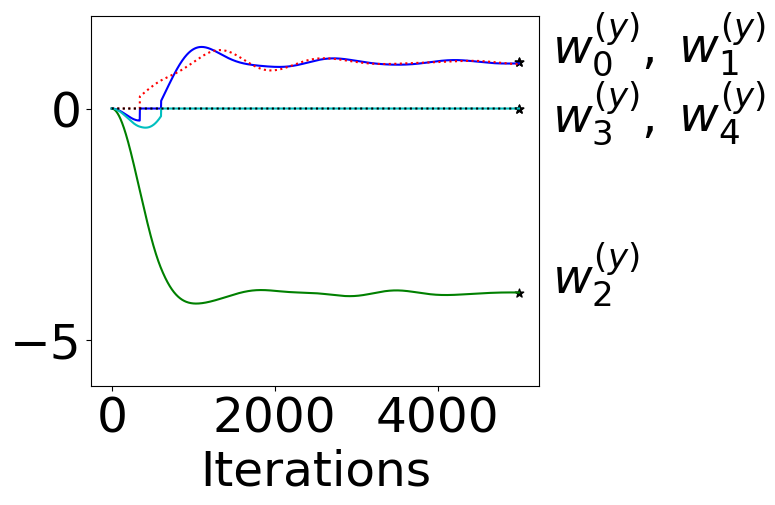

In [92]:
plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
names = ['$w^{(y)}_0,$', '$ ~~~~~~~~ w^{(y)}_1$', '$w^{(y)}_2$', '$w^{(y)}_3,$', '$ ~~~~~~~~ w^{(y)}_4$' ]
motives = ['-', ':', '-', '-', ':']
neg_log_alphas_enet = range(5000)
for i, (coef_e, c) in enumerate(zip(betas, colors)):
    l2 = plt.plot(neg_log_alphas_enet, coef_e, motives[i], c=c, label=f'$w_{i}$')
    # plt.legend(loc='lower left', handlelength=0.4)


markers = ["<", ">", "v", "^", "*"]

for i, (wi, c, m) in enumerate(zip([1, 1, -4, 0, 0], colors, markers)):
    if i == 3 or i == 4:
        position = wi - 0.5
    else:
        position = wi
    plt.scatter([neg_log_alphas_enet[-1]], [wi], c='black', marker='*', s=40)
    plt.text(neg_log_alphas_enet[-1]+ 400 , position, names[i])

plt.xlabel("Iterations")
# plt.ylabel("coeffs")
# plt.title("IRKSN Early Stopping Path")
plt.axis("tight")
plt.ylim(-6, 2)
plt.subplots_adjust(left=0.2)

plt.show()
